## Discrete Fourier Transform (DFT)


In [ ]:
%pip install ipympl
import numpy as np 
from scipy import signal
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
import io
from scipy.io import wavfile
from pyodide.http import pyfetch
%matplotlib ipympl

# function for reading WAV files from a URL. Must be a RAW link, not GitHub HTML
vocal_sample = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/vocal_sample.wav"

async def read_wav_from_url(url):
    response = await pyfetch(url)
    wav_bytes = await response.bytes()  # get raw binary
    fs, data = wavfile.read(io.BytesIO(wav_bytes))

    # convert to float in [-1, 1]
    if np.issubdtype(data.dtype, np.integer):
        max_val = np.iinfo(data.dtype).max
        data = data.astype(np.float32) / max_val
    else:
        data = data.astype(np.float32)  # already float
    
    return data, fs

### Fast Fourier Transform (FFT)

The Fast Fourier Transform (FFT), as the name implies, is a fast algorithm that is notorious for implementing a Discrete Fourier Transform (DFT). In Python and many other programming languages, there are pre-defined packages which compute the FFT. In Python, the FFT is done in the numpy package. 

Let's record a signal and have a look at its frequency spectrum, i.e. we will apply the FFT algorithm to implement the DFT of our recorded signal. We will use a sampling frequency, $f_{s} =  8 $ kHz and denote the total number of samples in the signal as $N$.


Number of samples, N = 48000


<IPython.core.display.Javascript object>


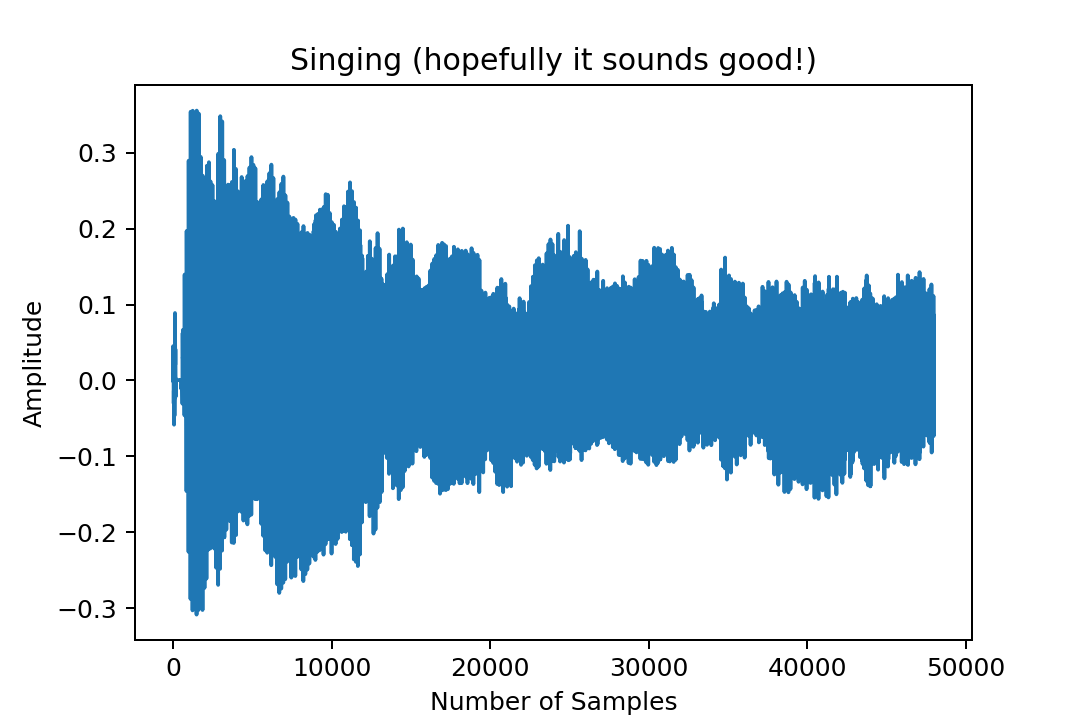

Text(0, 0.5, 'Amplitude')

In [ ]:
# Import  signal
yy, fs = await read_wav_from_url(vocal_sample)
yy = yy - np.mean(yy) # Removing the mean of the signal

t = np.arange(0,len(yy),1)*(1/fs) # time vector

IPython.display.display(Audio(yy.T, rate=fs))
      
fig, axes = plt.subplots() 
axes.plot(t, yy)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
plt.show()

Okay, so we have recorded a signal of 3 seconds at a sampling frequency of 8 kHz. 

The next step is to take the FFT of this signal. Recall that this FFT is going to give us both real and imaginary values, which means that we can plot both the magnitude and phase of the signal. The FFT function returns a vector of complex values, however, we need to know what frequency each of these values correspond to. In other words, we need to set up the corresponding frequency vector. This can be done using the python function np.fft.fftfreq, but we will make it ourselves so that we have a better understanding. The frequency bin spacing, $df$ between the samples is given by:

\begin{equation}
df = \frac{f_{s}}{N}
\end{equation}

This equation tells us that we can essentially increase our frequency resolution by including more points or by reducing the sampling frequency. This does not come without consequences however. When increasing the number of points, it means that we lose some temporal resolution of the signal (as we will see a bit later). If we alternatively reduce the sampling frequency, although we increase the resolution, we will reduce the maximum frequency up to which we have information (recall the Nyquist-Shannon sampling theorem from the whistling demo!).

Using this frequency bin spacing we can then make a vector starting from DC (0 Hz) to $f_{s}-df$. This will however include the double sided spectrum. In many practical cases, we may however only be interested in the single-sided spectrum, which goes up to $f_{s}/2$. 

More info. on the numpy fft routines are given here:
https://numpy.org/doc/stable/reference/routines.fft.html

Observe the frequency spectrum, if you made a sound such as 'ahhh', you should observe several peaks which may be harmonically related. 


<IPython.core.display.Javascript object>


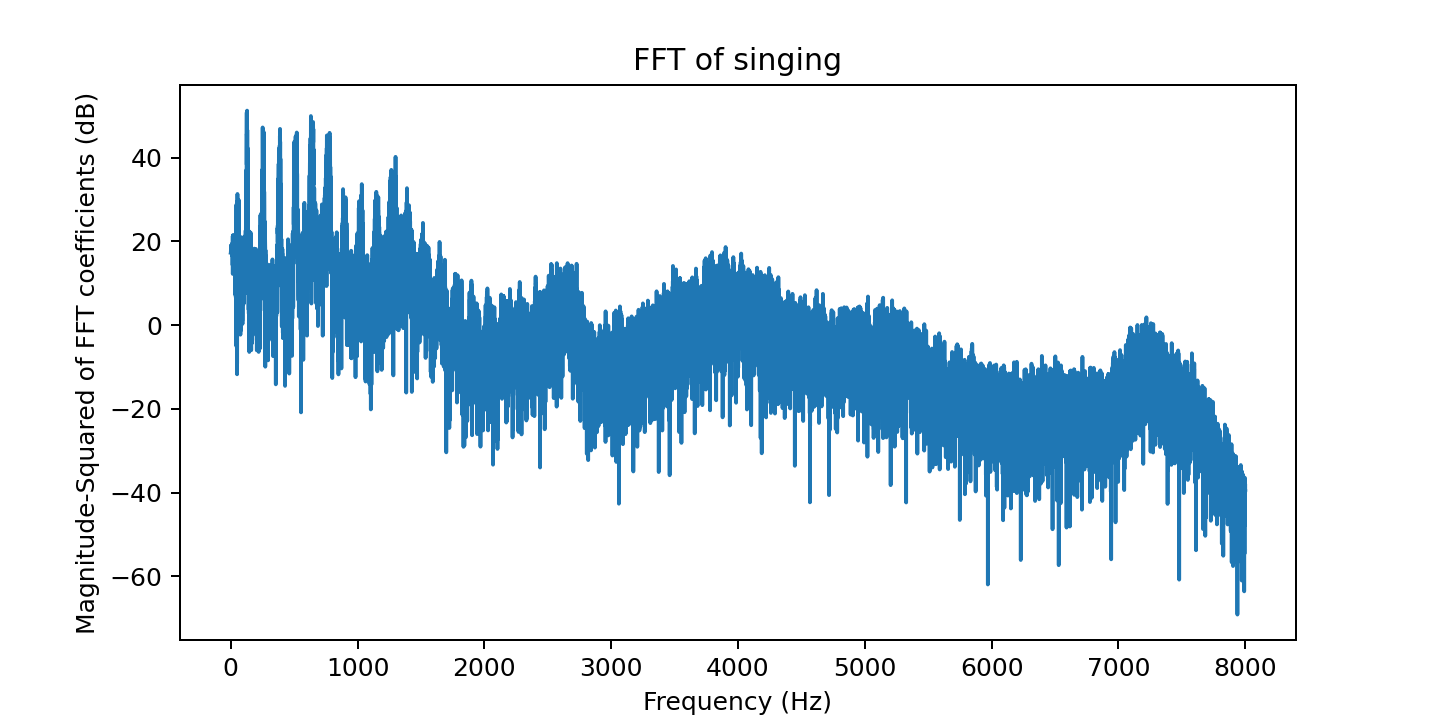

48000
Take a look at how the values are repeated after N/2
[-0.01263305-0.00119884j]
[-0.01017429+0.00074211j]
[-0.01042293+3.05311332e-16j]
[-0.01017429-0.00074211j]
[-0.01263305+0.00119884j]


In [ ]:
# Apply the FFT to the signal

N = len(yy)
YY = np.fft.fft(yy,axis=0)  # make sure to specify the axis. zero in this case since the data is along the first axis.
                            # Since yy was an Nx1 vector, python wants to know just where the "N" values are, i.e. in axis = 0
YYss = YY[0:N//2+1]  # Single sided spectrum. The last value will be N/2, since python goes up to N-1 when slicing vectors like this.

#Set up the frequency vector
df = fs/N  # the frequency bin spacing
freqs = np.arange(0,fs/2+df,df) # first value = DC, last value = fs/2

# Let us plot the Magnitude-Squared 

fig, axes = plt.subplots() 
axes.plot(freqs,10*np.log10(np.abs(YYss**2)))
axes.set_title('FFT of singing')
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Magnitude-Squared of FFT coefficients (dB)')
axes.set_xlim([0, 10000])
axes.set_ylim([-20, 80])


print(N)

print ("Take a look at how the values are repeated after N/2")
print(YY[N//2 - 2])
print(YY[N//2 - 1])
print(YY[N//2])
print(YY[N//2 + 1])
print(YY[N//2 + 2])

In [ ]:
# Interactive plot
frame_size=0.2 # Frame size in seconds
hop_size=frame_size/2  # Hop size in seconds
frame_len = int(frame_size * fs) # Frame length in samples
hop_len   = int(hop_size * fs) # Hop length in samples

fig, axes = plt.subplots(2,1)
waveform, = axes[0].plot([], [])
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amp')
axes[0].set_xlim([0, frame_size])
axes[0].set_ylim([-0.2, 0.2])

fftplot, = axes[1].plot([], [], label='original')
fftpeaks, = axes[1].plot([], [], "mx",linewidth=2)
axes[1].set_xlim([0, 4000])
axes[1].set_ylim([-150, -50])

axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('dB/Hz')
# axes[1].legend()



# number of complete frames we can fit
n_frames = 1 + (len(y) - frame_len) // hop_len

energies = np.zeros(n_frames)
frame_times = np.zeros(n_frames)
zcr = np.zeros(n_frames)


def update(i=0):

    start = i * hop_len
    frame = yy[start:start+frame_len]
    fig.canvas.draw_idle()
    
    YY = np.fft.fft(yy,axis=0)  # make sure to specify the axis. zero in this case since the data is along the first axis.
                            # Since yy was an Nx1 vector, python wants to know just where the "N" values are, i.e. in axis = 0
    YYss = YY[0:N//2+1]  # Single sided spectrum. The last value will be N/2, since python goes up to N-1 when slicing vectors like this.

    df = fs/N  # the frequency bin spacing
    freqs = np.arange(0,fs/2+df,df) # first value = DC, last value = fs/2
    
    t = np.arange(0,frame_len/fs,1/fs)
    # print(start/fs)
    # print(frame_len/fs)
    
    waveform.set_data(t, frame)
    fftplot.set_data(freqs, YYss)

    IPython.display.display(Audio(frame.T, rate=fs,normalize=True))

print('Move the slider to see how the hyperparameters affect performance ')
interact(update, i=(0,n_frames,1));




